# Import necessary libraries

In [ ]:
import os
import random
import numpy as np

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix  # For evaluating the model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
from tensorflow.keras.preprocessing import image


TensorFlow version: 2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt

data_dir = '/content/drive/My Drive/data'
images_dir = os.path.join(data_dir, 'HeadCT')
labels_path = os.path.join(data_dir, 'labels.csv')

print("Loading labels from CSV...")
labels_df = pd.read_csv(labels_path)
print("Labels DataFrame head:")
print(labels_df.head())

print("Mapping 'infected' column to binary values...")
labels_df['infected'] = labels_df['infected'].map({'yes': 1, 'no': 0})
print("0/1 Labels DataFrame:")
print(labels_df.head())

labels_df['infected'] = labels_df['infected'].map({1: 'yes', 0: 'no'})

print("Updated Labels DataFrame:")
print(labels_df.head())

img_size = (224, 224)
print(f"Target image size set to: {img_size}")

print("Creating ImageDataGenerator for image preprocessing...")
datagen = ImageDataGenerator(
    rescale=1./255
)

print("Creating data generator for loading and preprocessing images...")


train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=images_dir,
    x_col='filename',
    y_col='infected',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

print("Data generator details:")
print(f"  - Batch size: {train_generator.batch_size}")
print(f"  - Total samples in dataset: {train_generator.samples}")
print(f"  - Total batches per epoch: {train_generator.samples // train_generator.batch_size}")


Loading labels from CSV...
Labels DataFrame head:
      filename infected
0  000000.jpeg       no
1  000001.jpeg      yes
2  000002.jpeg      yes
3  000003.jpeg       no
4  000004.jpeg      yes
Mapping 'infected' column to binary values...
0/1 Labels DataFrame:
      filename  infected
0  000000.jpeg         0
1  000001.jpeg         1
2  000002.jpeg         1
3  000003.jpeg         0
4  000004.jpeg         1
Updated Labels DataFrame:
      filename infected
0  000000.jpeg       no
1  000001.jpeg      yes
2  000002.jpeg      yes
3  000003.jpeg       no
4  000004.jpeg      yes
Target image size set to: (224, 224)
Creating ImageDataGenerator for image preprocessing...
Creating data generator for loading and preprocessing images...
Found 8580 validated image filenames belonging to 2 classes.
Data generator details:
  - Batch size: 32
  - Total samples in dataset: 8580
  - Total batches per epoch: 268


# Visualizing Data 

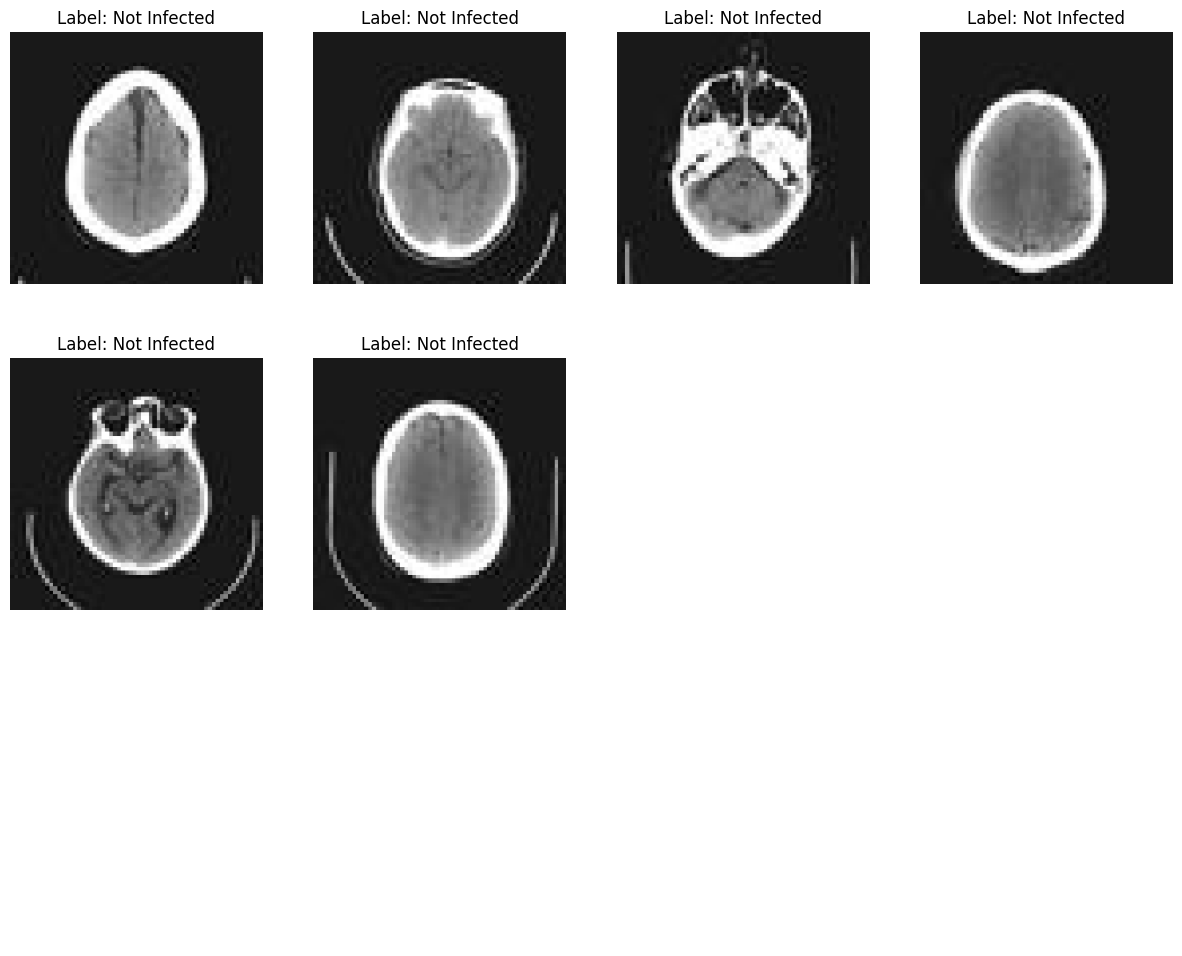

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_random_images(generator, num_images=12):

    images, labels = next(generator)

    random_indices = random.sample(range(images.shape[0]), num_images)

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))  # 3x4 grid

    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx])
        axes[i].axis('off')
        label = 'Infected' if labels[idx] == 1 else 'Not Infected'
        axes[i].set_title(f"Label: {label}")

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.show()

plot_random_images(train_generator, num_images=6)


<ipython-input-21-f210de2282ab>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


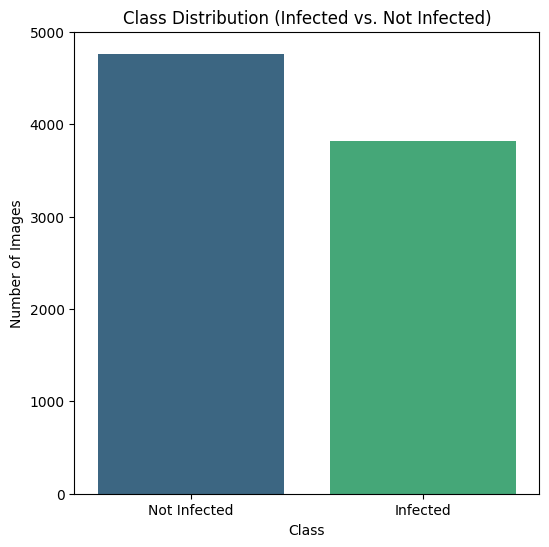

In [ ]:
import seaborn as sns

def plot_class_distribution(df):

    class_counts = df['infected'].value_counts()

    plt.figure(figsize=(6, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Class Distribution (Infected vs. Not Infected)')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks([0, 1], ['Not Infected', 'Infected'])
    plt.show()

plot_class_distribution(labels_df)

# Train/test split and Normalization 

In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming labels_df and images_dir are already defined
img_size = (224, 224)

# Split data into train (64%), validation (16%), and test (20%)
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)  # 80% train-validation, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)  # 80% train, 20% validation of the train-validation split

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=images_dir,
    x_col='filename',
    y_col='infected',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=images_dir,
    x_col='filename',
    y_col='infected',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=images_dir,
    x_col='filename',
    y_col='infected',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5491 validated image filenames belonging to 2 classes.
Found 1373 validated image filenames belonging to 2 classes.
Found 1716 validated image filenames belonging to 2 classes.


# Create a BinaryClassifier class 

In [ ]:

import tensorflow as tf

class BinaryClassifier:
    def __init__(self, learning_rate=0.001):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss = 'binary_crossentropy'
        self.metrics = ['accuracy']

    def compile_model(self):
        """Compiles the model with optimizer, loss, and metrics."""
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)


# Training Loop 

In [ ]:


def evaluate(classifier, test_generator):
      """Evaluates the model on the test set."""
      loss, accuracy = classifier.model.evaluate(test_generator, verbose=0)
      print(f"Test Loss: {loss:.4f}")
      print(f"Test Accuracy: {accuracy:.4f}")
      return loss, accuracy


def fit_one_epoch(classifier, train_generator, val_generator):
    """Performs one epoch of training and evaluates on validation set."""
    # Train for one epoch
    train_history = classifier.model.fit(train_generator, epochs=1, verbose=1)

    # Evaluate on validation set
    val_loss, val_accuracy = classifier.model.evaluate(val_generator, verbose=0)
    print(f"  Validation Loss: {val_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")

    return train_history, val_loss, val_accuracy


def fit(classifier, train_generator, val_generator, epochs=10):
    """Trains the model for multiple epochs and evaluates on validation set."""
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_history, val_loss, val_accuracy = fit_one_epoch(classifier, train_generator, val_generator)

        history['train_loss'].append(train_history.history['loss'][0])
        history['train_accuracy'].append(train_history.history['accuracy'][0])

        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"  Training Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Training Accuracy: {history['train_accuracy'][-1]:.4f}")
        print(f"  Validation Loss: {history['val_loss'][-1]:.4f}")
        print(f"  Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
        print("-" * 30)

    return history


# Plot Accuracy and Loss Curves 


In [35]:

def plot_training_curves(history):
    """Plots training and validation curves for accuracy and loss."""
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    # plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    # plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:

classifier = BinaryClassifier()
classifier.compile_model()

history = fit(classifier, train_generator, val_generator, epochs=5)
# plot_training_curves(history)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 739s 4s/step - accuracy: 0.8950 - loss: 0.3337
  Validation Loss: 0.0379
  Validation Accuracy: 0.9847
  Training Loss: 0.1420
  Training Accuracy: 0.9474
  Validation Loss: 0.0379
  Validation Accuracy: 0.9847
------------------------------
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - accuracy: 0.9753 - loss: 0.0675
  Validation Loss: 0.0300
  Validation Accuracy: 0.9862
  Training Loss: 0.0621
  Training Accuracy: 0.9754
  Validation Loss: 0.0300
  Validation Accuracy: 0.9862
------------------------------
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 723s 4s/step - accuracy: 0.9767 - loss: 0.0574
  Validation Loss: 0.0259
  Validation Accuracy: 0.9891
  Training Loss: 0.0450
  Training Accuracy: 0.9811
  Validation Loss: 0.0259
  Validation Accuracy: 0.9891
------------------------------
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 722s 4s/step - accuracy: 0.9861 - loss: 0.0345
  Validation Loss: 0.0905
  Validation Accuracy: 0.9665
  Training Loss: 0.0369
 

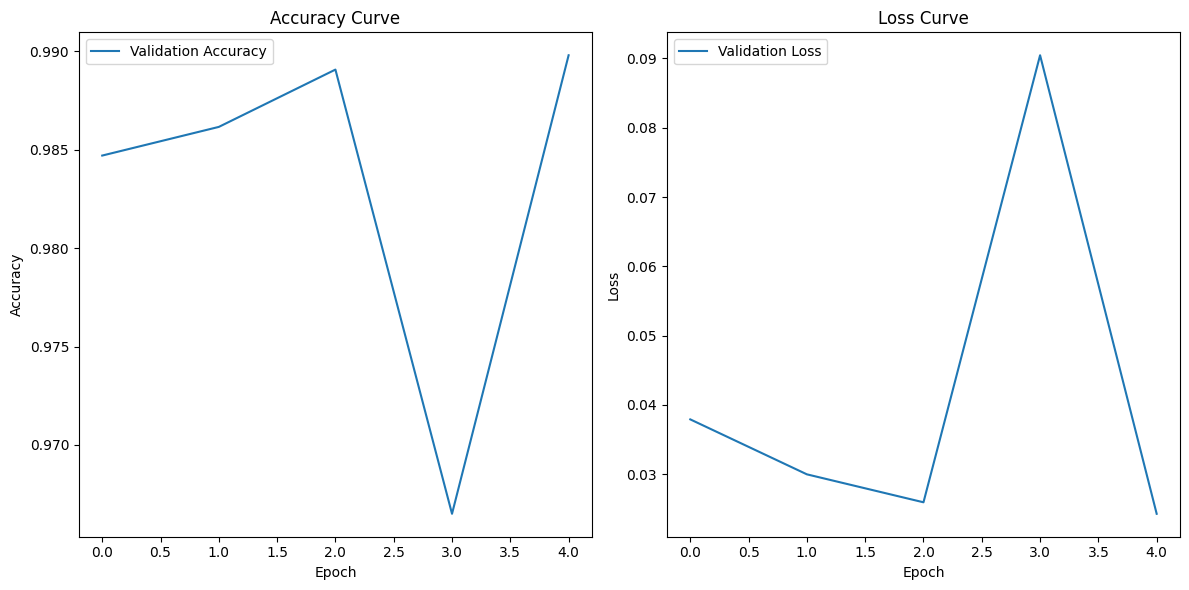

In [36]:
plot_training_curves(history)

# Evaluate on the test set 

In [ ]:

val_loss, val_accuracy = evaluate(classifier, test_generator)

print(f"Test Loss: {val_loss:.4f}")
print(f"Test Accuracy: {val_accuracy:.4f}")


Test Loss: 0.0357
Test Accuracy: 0.9872
Test Loss: 0.0357
Test Accuracy: 0.9872


# Evaluation Metrics 

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       953
           1       0.99      0.98      0.99       763

    accuracy                           0.99      1716
   macro avg       0.99      0.99      0.99      1716
weighted avg       0.99      0.99      0.99      1716

Confusion Matrix:
[[944   9]
 [ 13 750]]


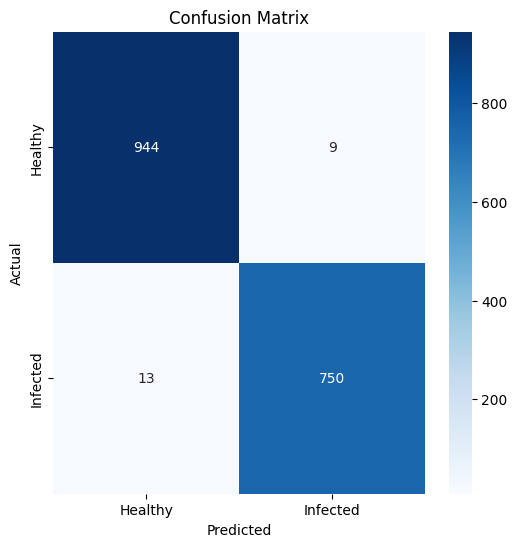

Area Under the ROC Curve (AUC): 0.9994


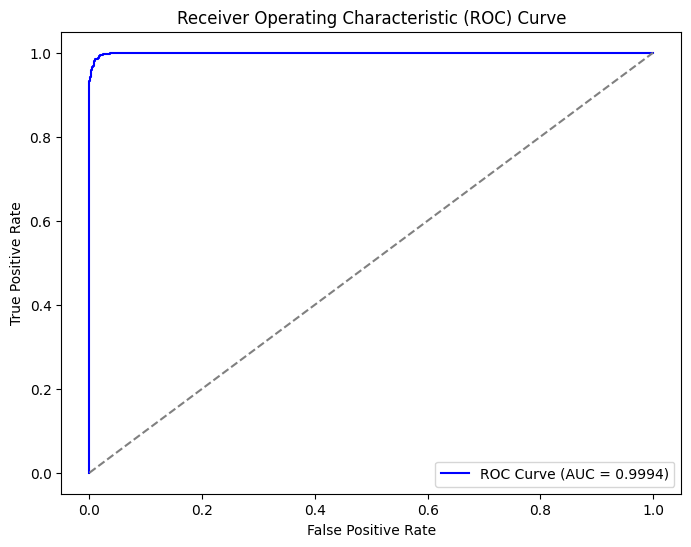

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_metrics(classifier, test_generator):
    test_labels = test_generator.classes
    predictions = classifier.model.predict(test_generator, verbose=0)
    predicted_labels = (predictions > 0.5).astype("int32")
    print("Classification Report:")
    print(classification_report(test_labels, predicted_labels))

    cm = confusion_matrix(test_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Infected"], yticklabels=["Healthy", "Infected"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    roc_auc = auc(fpr, tpr)

    print(f"Area Under the ROC Curve (AUC): {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

evaluate_metrics(classifier, test_generator)


# Where did it go wrong?  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Misclassified indices: [16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
Misclassified indices: [7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
Misclassified indices: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Misclassified indices: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Miscla

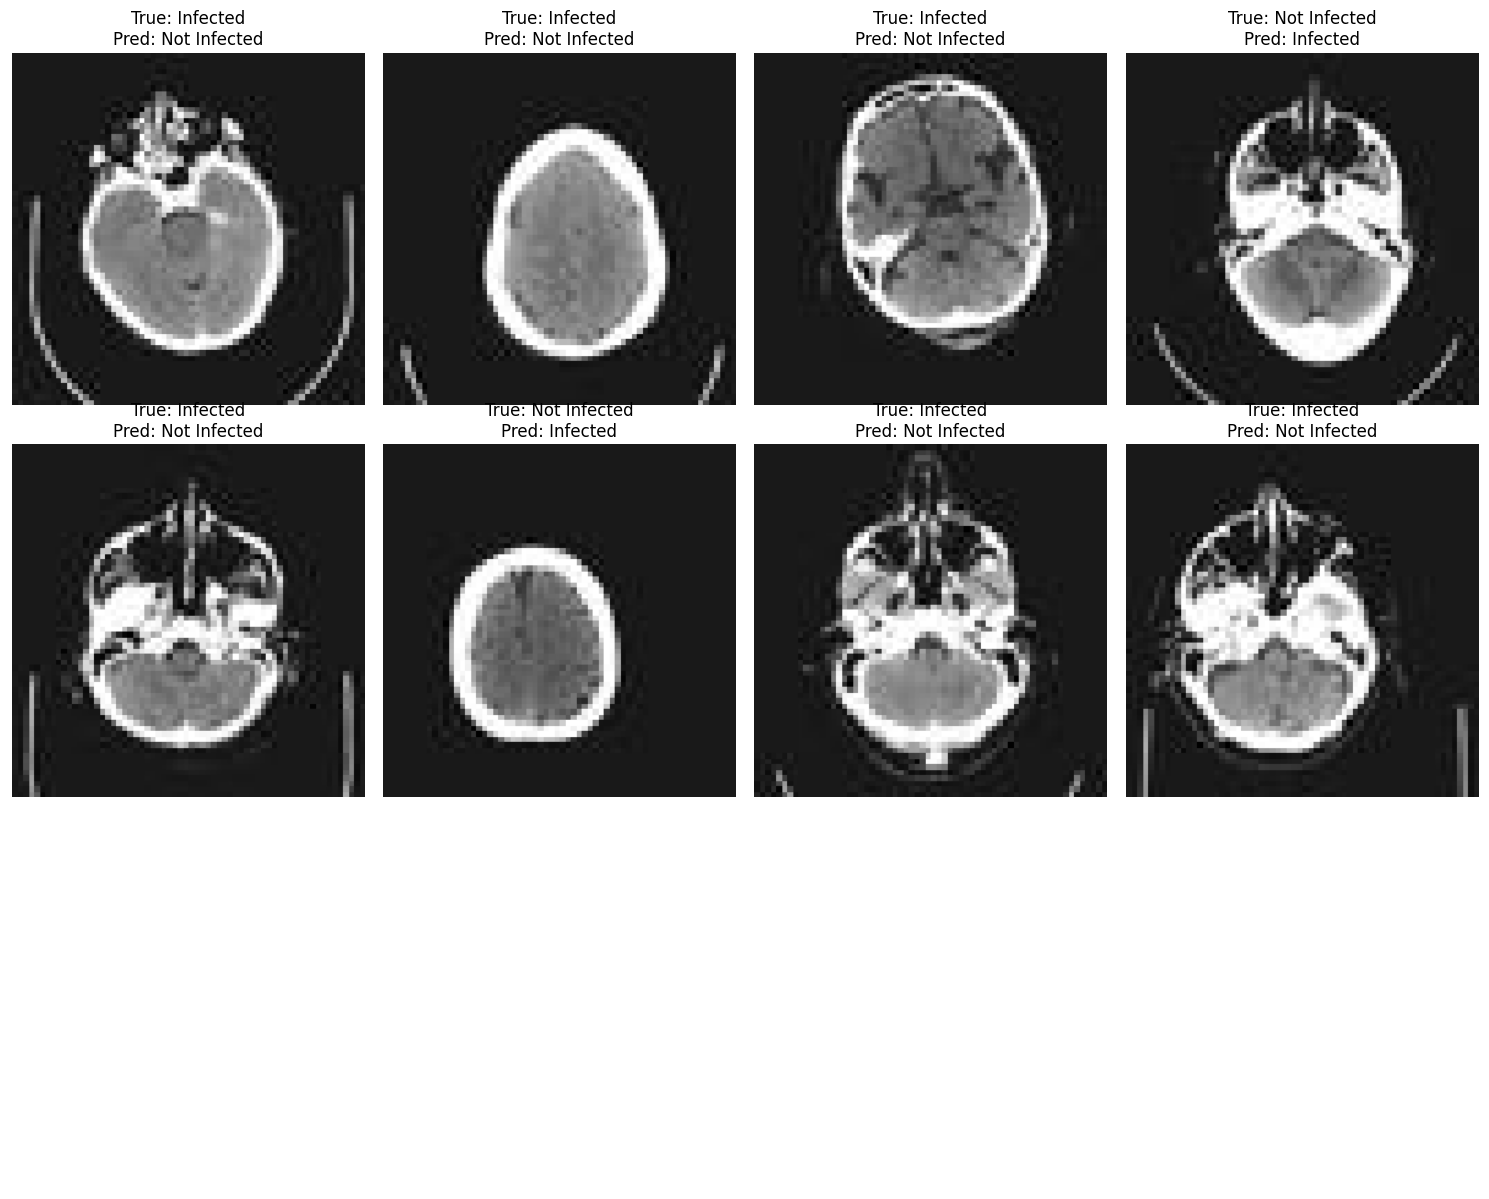

In [ ]:

import random
import numpy as np
import matplotlib.pyplot as plt

def plot_misclassified_images(classifier, test_generator, num_images=12):
    """Plots misclassified images along with their true and predicted labels."""
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []

    for images, true_labels in test_generator:
        predictions = classifier.model.predict(images)
        predicted_labels = (predictions.flatten() > 0.5).astype("int32")
        misclassified_indices = np.where(predicted_labels != true_labels)[0]

        print(f"Misclassified indices: {misclassified_indices[:5]}")
        misclassified_images.extend(images[misclassified_indices])
        misclassified_true_labels.extend(true_labels[misclassified_indices])
        misclassified_pred_labels.extend(predicted_labels[misclassified_indices])
        if len(misclassified_images) >= num_images:
            break

    misclassified_images = misclassified_images[:num_images]
    misclassified_true_labels = misclassified_true_labels[:num_images]
    misclassified_pred_labels = misclassified_pred_labels[:num_images]

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, img in enumerate(misclassified_images):
        axes[i].imshow(img)
        axes[i].axis('off')

        true_label = 'Infected' if misclassified_true_labels[i] == 1 else 'Not Infected'
        predicted_label = 'Infected' if misclassified_pred_labels[i] == 1 else 'Not Infected'

        print(f"Misclassified Image {i+1}: True: {true_label}, Pred: {predicted_label}")

        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")

    for i in range(len(misclassified_images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_misclassified_images(classifier, test_generator, num_images=8)